In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import gym

from time import time

import torch
from torch import nn
from torch.nn import functional as F

from collections import deque
from functools import reduce

%matplotlib inline

# Vanilla Reinforce Implementation

In [2]:
class VanillaReinforceAgent:
    def __init__(self, env, gamma=0.99, lr=0.1, PolicyClass=None,
                       device_name="cpu",
                       device=torch.device("cpu")):
        self.gamma = gamma
        self.device = device
        self.device_name = device_name

        if env.observation_space.shape:
            state_size = reduce(lambda x, y: x*y, env.observation_space.shape)
        else:
            state_size = env.observation_space.n
        self.num_actions = env.action_space.n
        self.policy = (PolicyClass)(state_size, self.num_actions)

        self.policy.to(device=device)

        self.optimizer = torch.optim.RMSprop(self.policy.parameters(), lr=lr)

    def load_state(self, path):
        pass

    def get_action(self, state):
        """
            Returns (action, log (pi(a_t | s_t)))
        """
        device = self.device

        st = torch.Tensor(state[None, :]).to(device=device)
        p = self.policy(st)
        p2 = p[0].detach().numpy() if self.device_name == "cpu" else p[0].cpu().detach().numpy()
        choice = np.random.choice(range(self.num_actions), p=p2)
        return (choice, p[0, choice].log())

    def start_episode(self):
        self.states = deque([])
        self.rewards = deque([])
        self.actions = deque([])
        self.logprobs = deque([])

    def step(self, state, action, reward, logprob):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)
        self.logprobs.append(logprob)

    def chain_train(self):
        """
            Takes a Monte Carlo episode and trains the policy
            on it

            chain = [ (state, action, reward, done, next_state), ... ]
        """
        discounted_rewards = deque([])
        cum_rew = 0
        full_rew = 0
        rewards = np.array(self.rewards)
        for reward in reversed(rewards):
            full_rew += reward
            cum_rew = reward + self.gamma*cum_rew
            discounted_rewards.appendleft(cum_rew)

        device = self.device
        discounted_rewards = torch.Tensor(discounted_rewards).to(device=device)
        logprobs = torch.stack(tuple(self.logprobs)).to(device=device)
        loss = - torch.sum( discounted_rewards*logprobs )

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save(self):
        torch.save(self.policy.state_dict(), "cartpole_policy_cpu.pkl")

    def load(self):
        if self.device_name == "cuda":
            self.policy.load_state_dict(torch.load("cartpole_policy.pkl"))
        else:
            self.policy.load_state_dict(
                    torch.load("cartpole_policy.pkl", map_location=lambda storage, loc: storage))

# Training method

In [3]:
def train(args):
    env = gym.make(args["ENVIRONMENT"])
    agent = (args["AGENT"])(env, lr=args["LEARNING_RATE"],
                            PolicyClass=args["POLICY"])
    ema_reward = 0

    stats = {
        "reward_ema": deque([])
    }

    if args["LOAD_POLICY"]: agent.load()

    for i in range(args["NUM_EPISODES"]):
        t = time()
        state = env.reset()
        done = False
        agent.start_episode()
        total = 0
        while not done:
            action, logprob = agent.get_action(state)
            new_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, logprob)
            total += reward

            if args["RENDER_ENV"]:
                env.render()

            state = new_state

        ema_reward = 0.9*ema_reward + 0.1*total
        stats["reward_ema"].append(ema_reward)
        agent.chain_train()
        
#         print("Time taken", time()-t)

        if i%10==0:
            print("Finished episode", i)
            agent.save()
            print("EMA of Reward is", ema_reward)

        if args["STOP_AT_THRESHOLD"] and (ema_reward >= env.spec.reward_threshold):
            print("We have arrived in the AI age")
            agent.save()
            break

    return stats

# Training a two layer network on CartPole-v0

In [4]:
class Policy(nn.Module):
    """
        Map state to action probabilities
    """
    def __init__(self, state_size, num_actions, h1=64, h2=64):
        super().__init__()

        self.fc1 = nn.Linear(state_size, h1)
        self.fc2 = nn.Linear(h1, num_actions)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.softmax(self.fc2(out), dim=1)

        return out

In [61]:
stats = train({
                "NUM_EPISODES": 750,
                "LEARNING_RATE": 0.001,
                "ENVIRONMENT": "CartPole-v0",
                "DEVICE": "cpu",
                "AGENT": VanillaReinforceAgent,
                "POLICY": Policy,
                "RENDER_ENV": False,
                "LOAD_POLICY": False,
                "STOP_AT_THRESHOLD": False
            })


Finished episode 0
EMA of Reward is 1.6
Finished episode 10
EMA of Reward is 20.124968659460002
Finished episode 20
EMA of Reward is 26.643005032441906
Finished episode 30
EMA of Reward is 31.204947934388297
Finished episode 40
EMA of Reward is 33.719580323364234
Finished episode 50
EMA of Reward is 36.3098147527773
Finished episode 60
EMA of Reward is 34.82635292551836
Finished episode 70
EMA of Reward is 36.16012115094182
Finished episode 80
EMA of Reward is 36.82745510513742
Finished episode 90
EMA of Reward is 40.65034072381209
Finished episode 100
EMA of Reward is 37.75128538411231
Finished episode 110
EMA of Reward is 35.95892133540222
Finished episode 120
EMA of Reward is 42.117728913306664
Finished episode 130
EMA of Reward is 43.28307080974645
Finished episode 140
EMA of Reward is 42.54323892208024
Finished episode 150
EMA of Reward is 43.80000845485255
Finished episode 160
EMA of Reward is 42.3890742635048
Finished episode 170
EMA of Reward is 46.130672404181915
Finished epis

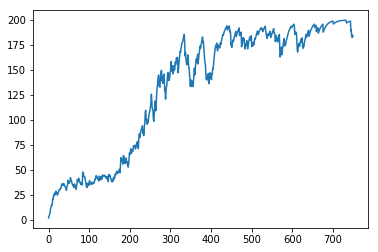

In [62]:
plt.plot(stats['reward_ema'])

# Other environments

In [5]:
stats = train({
    "NUM_EPISODES": 750,
    "LEARNING_RATE": 0.001,
    "ENVIRONMENT": "Acrobot-v1",
    "DEVICE": "cpu",
    "AGENT": VanillaReinforceAgent,
    "POLICY": Policy,
    "RENDER_ENV": False,
    "LOAD_POLICY": False,
    "STOP_AT_THRESHOLD": False
})

Finished episode 0
EMA of Reward is -50.0
Finished episode 10
EMA of Reward is -318.8719369843
Finished episode 20
EMA of Reward is -316.0812515625513
Finished episode 30
EMA of Reward is -305.1372519327861
Finished episode 40
EMA of Reward is -265.83472299782454
Finished episode 50
EMA of Reward is -261.2799133390971
Finished episode 60
EMA of Reward is -238.2710276473396
Finished episode 70
EMA of Reward is -216.71881173019838
Finished episode 80
EMA of Reward is -204.28215713831122
Finished episode 90
EMA of Reward is -208.67036588944947
Finished episode 100
EMA of Reward is -202.67700407602953
Finished episode 110
EMA of Reward is -185.38267401507136
Finished episode 120
EMA of Reward is -190.2936752993419
Finished episode 130
EMA of Reward is -231.25248375387045
Finished episode 140
EMA of Reward is -228.94482490955022
Finished episode 150
EMA of Reward is -226.88318968992965
Finished episode 160
EMA of Reward is -215.33367735759708
Finished episode 170
EMA of Reward is -201.19500

# Why doesn't it work on MountainCar-v0?

## Negative rewards mess up the gradient ascent step, make a  descent instead?
We put in positive rewards to encourage a string of actions that led to good things. But when we get negative rewards, the good actions get discouraged instead.  
***Solution***: Use squared rewards instead? but that's stupid if `Gt` can be both negative and positive

# Actor Critic with State Values